In [15]:
import numpy as np
import wfdb
import glob
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pywt
import pywt.data
import os
from pathlib import Path
from PIL import Image,ImageEnhance
from scipy import fftpack
import shutil
import pandas as pd
import random
import scipy.signal as signal
from wfdb import processing
from itertools import combinations
import ast
import wfdb

In [16]:
import numpy as np
import pandas as pd

import psutil
import GPUtil

import os,sys,humanize,psutil,GPUtil

import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import matplotlib.image as mpimg
import imageio
import glob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset  # Import the Dataset class

# rescale, dataset, dataloader

In [3]:
'''
class TimeSeriesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): 'asmi'와 'normal' 폴더가 포함된 최상위 디렉토리 경로.
            transform (callable, optional): 샘플에 적용될 선택적 변환.
        """
        self.transform = transform
        self.samples = []

        # asmi 폴더의 파일에 라벨 1 할당
        asmi_files = glob.glob(os.path.join(root_dir, 'asmi', '*.npy'))
        self.samples.extend([(file, 1) for file in asmi_files])

        # normal 폴더의 파일에 라벨 0 할당
        normal_files = glob.glob(os.path.join(root_dir, 'normal', '*.npy'))
        self.samples.extend([(file, 0) for file in normal_files])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        # .npy 파일 로드
        data = np.load(file_path)
        
        # PyTorch 텐서로 변환
        data = torch.from_numpy(data).float()
        
        if self.transform:
            data = self.transform(data)
        
        return data, label
'''

In [17]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 255.0)
])

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment_transform=None):
        self.transform = transform
        self.augment_transform = augment_transform
        self.samples = []

        asmi_files = glob.glob(os.path.join(root_dir, 'asmi', '*.npy'))
        self.samples.extend([(file, 1) for file in asmi_files])

        normal_files = glob.glob(os.path.join(root_dir, 'normal', '*.npy'))
        self.samples.extend([(file, 0) for file in normal_files])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        data = np.load(file_path)

        # PyTorch 텐서로 변환 후 데이터 증강 또는 변환 적용
        data = torch.from_numpy(data).float()
        if label == 1 and self.augment_transform:
            data = self.augment_transform(data)
        elif self.transform:
            data = self.transform(data)
        
        # 데이터를 (64, 4, 125) 형태로 reshape
        data = data.view(10,50)
        
        return data, label

In [6]:
train_dir = os.path.join('/home/ines/code/ptb-xl/X_train_V1/')
test_dir = os.path.join('/home/ines/code/ptb-xl/X_test_V1/')

In [7]:
# 데이터 증강을 위한 변환 정의
augment_transform = transforms.Compose([
    transforms.Lambda(lambda x: x * torch.rand(1) + 0.5)  # 예시: 무작위 스케일링
])

# 데이터셋 인스턴스 생성 시 'asmi' 클래스에 적용할 augment_transform 전달
train_da = TimeSeriesDataset(root_dir=train_dir,
                                  transform=transform,
                                  augment_transform=augment_transform)
test_da = TimeSeriesDataset(root_dir=test_dir,
                                  transform=transform,
                                  augment_transform=augment_transform)

In [8]:
# 데이터셋 및 DataLoader 생성
# train_da = TimeSeriesDataset(root_dir=train_dir, transform = transform)
# test_da = TimeSeriesDataset(root_dir=test_dir, transform = transform)

train_dl = DataLoader(train_da, batch_size=64, shuffle=True, num_workers=4)
test_dl = DataLoader(test_da, batch_size=64, shuffle=True, num_workers=4)

In [18]:
for text, label in test_dl:
    print(text)
    break

tensor([[[-8.4459e-05, -2.6030e-04, -1.9220e-04,  ...,  4.9653e-05,
          -2.0452e-04, -1.2809e-04],
         [-1.6520e-04,  1.9760e-05, -1.3585e-04,  ..., -3.2164e-05,
           1.1369e-04, -3.8591e-06],
         [ 1.1032e-04,  1.1554e-05,  3.8055e-05,  ..., -7.1591e-05,
          -1.4539e-04, -9.7935e-05],
         ...,
         [ 2.0318e-04,  1.8921e-04,  2.3036e-04,  ...,  1.4593e-04,
           1.1875e-04, -1.9440e-05],
         [-1.1107e-04,  2.2202e-05,  9.2574e-06,  ..., -2.0905e-03,
          -1.3649e-03,  6.4607e-04],
         [-8.6079e-05,  3.4697e-04, -7.9501e-06,  ...,  6.2204e-04,
           3.6242e-04,  1.2173e-04]],

        [[ 6.3824e-04,  1.0811e-04,  2.3923e-04,  ..., -1.0857e-04,
          -1.0603e-05, -7.5682e-06],
         [-6.1647e-06, -2.4137e-05,  1.3817e-04,  ...,  1.0480e-04,
           5.8432e-05,  1.0701e-04],
         [ 6.6870e-05,  5.4264e-05,  2.9754e-05,  ...,  1.2759e-04,
           1.6941e-05,  3.5552e-05],
         ...,
         [-4.9687e-04, -4

# 모델 정의 및 훈련

In [10]:
class ECGTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers):
        super(ECGTransformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        # Assuming that after processing we want a single scalar for each item in the batch
        # We use input_dim * sequence_length because we're going to flatten the output of the transformer
        self.fc = nn.Linear(input_dim * 50, 1)  # Adjust the multiplication factor according to your sequence length

    def forward(self, src):
        # src shape: [batch_size, channels, seq_len] -> [64, 12, 500]
        # Permuting and flattening to treat each channel's time step as separate feature
        src = src.permute(2, 0, 1)  # New shape: [seq_len, batch_size, channels] -> [500, 64, 12]
        out = self.transformer_encoder(src)
        # Flattening the output for the fully connected layer
        out = out.permute(1, 0, 2).flatten(start_dim=1)  # [64, 500*12]
        out = self.fc(out)  # [64, 1]
        out = torch.sigmoid(out)
        return out

In [11]:
# Parameters initialization
input_dim = 10 # Number of channels
num_heads = 5
num_layers = 4

model = ECGTransformer(input_dim=input_dim, num_heads=num_heads, num_layers=num_layers)

In [12]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
model.to(device)

device

device(type='cuda')

In [13]:
# Define Loss and Optimizer
criterion = nn.BCELoss()  # This loss combines a Sigmoid layer and the BCELoss in one single class
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

y_pred = []
y_true = []
tr_acc = []
valid_acc = []
tr_loss = []
valid_loss = []


for epoch in range(500):  # Loop over the dataset multiple times
    total_correct = 0
    total_samples = 0
    total_loss_epoch = 0
    for inputs, labels in train_dl:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)  # Move tensors to the same device as the model
        outputs = model(inputs)  # If inputs are already in the correct shape, no need to unsqueeze
        
        predicted = (outputs >= 0.5).float()  # 0.5를 기준으로 클래스를 나눕니다
        correct = (predicted.squeeze(1) == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)        

        loss = criterion(outputs, labels.unsqueeze(1).float())
        acc = 100 * total_correct / total_samples
        loss.backward()
        optimizer.step()
        total_loss_epoch += loss.item()

    avg_loss_epoch = total_loss_epoch / len(train_dl)
    acc = 100 * total_correct / total_samples
    tr_acc.append(acc)
    tr_loss.append(avg_loss_epoch)
    print(f'Epoch {epoch+1}: loss {avg_loss_epoch: .4f}, Accuracy {acc: .2f}%')
    

    model.eval()
    with torch.no_grad():
        val_tot_correct = 0
        val_tot_samples = 0
        for images, labels in test_dl:
            images, labels = images.to(device), labels.to(device)
            val_outputs  = model(images)

            val_pred = (val_outputs >= 0.5).float().squeeze(1) # Make sure this results in a 1D tensor

            lab = labels.cpu().numpy()
            y_pred.append(val_pred)
            y_true.append(labels)

            
            
            val_cor = (val_pred == labels).sum().item()
            val_tot_correct += val_cor
            val_tot_samples += labels.size(0)
            
            val_loss = criterion(val_outputs, labels.unsqueeze(1).float())

    val_acc = 100 * val_tot_correct / val_tot_samples
    valid_acc.append(val_acc)
    valid_loss.append(val_loss.item())
    print(f'val_loss {val_loss: .4f}, Val_Accuracy {val_acc: .2f}%')
    # print("lr: ", optimizer.param_groups[0]['lr'])
    # scheduler.step()

Epoch 1: loss  0.0093, Accuracy  99.63%
val_loss  0.0002, Val_Accuracy  100.00%
Epoch 2: loss  0.0003, Accuracy  99.99%
val_loss  0.0001, Val_Accuracy  100.00%
Epoch 3: loss  0.0006, Accuracy  99.99%
val_loss  0.0000, Val_Accuracy  100.00%
Epoch 4: loss  0.0006, Accuracy  99.99%
val_loss  0.0000, Val_Accuracy  100.00%


KeyboardInterrupt: 

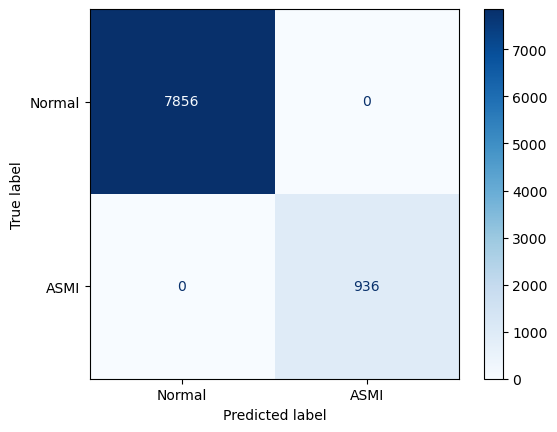

In [14]:
y_pred_tensor = torch.cat(y_pred).to('cpu')
y_true_tensor = torch.cat(y_true).to('cpu')

label_mapping = {'Normal': 0, 'ASMI': 1}

y_pred_numpy = y_pred_tensor.numpy()
y_true_numpy = y_true_tensor.numpy()

cm = confusion_matrix(y_true_numpy, y_pred_numpy)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'ASMI'])

# True label 파랑색으로 설정
disp.plot(include_values=True, cmap='Blues', xticks_rotation='horizontal', values_format='d')
plt.show()